In [12]:
from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from paramz.optimization import Optimizer
import numpy as np
import numdifftools
import scipy.optimize as sciopt

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)


In [13]:
n_per_output = [65, 100]
xss = list(map(np.random.rand, n_per_output))
nout = len(n_per_output)
yss = [np.sin(2 * np.pi * xs + i * 2 * np.pi / nout)
       + np.random.randn(len(xs)) * (i + 1) * 0.1 / nout
       for i, xs in enumerate(xss)]
ks = [RBF(name='rbf{}'.format(i)) for i in range(nout)]

In [14]:
def print_diagram(lmc):
    plot_xs =  np.arange(0, 1, 0.01)
    ys, var = lmc.predict([plot_xs for _ in range(nout)])
    for i, (y, v, xs, ys) in enumerate(zip(ys, var, xss, yss)):
        sd = np.sqrt(v)
        order = xs.argsort()
        plt.scatter(xs[order], ys[order])
        plt.title('output {} (95%)'.format(i))
        plt.plot(plot_xs, y)
        plt.plot(plot_xs, y + 2 * sd, ls='--', c='g')
        plt.plot(plot_xs, y - 2 * sd, ls='--', c='g')
        plt.show()

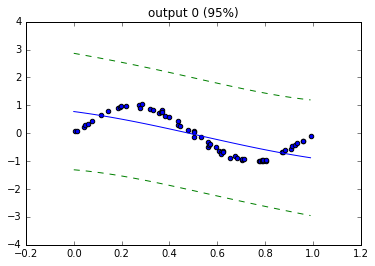

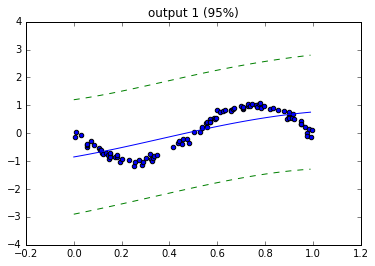

In [15]:
# Unoptimized
lmc = LMC(xss, yss, kernels=ks, normalize=False)
print_diagram(lmc)

In [16]:
class Opt(Optimizer):
    def __init__(self):
        super().__init__()

    def opt(self, x_init, f_fp=None, f=None, fp=None):
        options = {'iprint': 1, 'disp': True, 'maxiter': 10000}
        res = sciopt.minimize(
            f,
            x_init,
            method='L-BFGS-B',
            options=options)
        print(res.message)
        self.x_opt = res.x
    
lmc.optimize(optimizer=Opt())

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'



Name : lmc
Objective : -180.12188506086244
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |  priors
  rbf0.inv_lengthscale  |  29.0508452548  |      +ve      |        
  rbf1.inv_lengthscale  |  19.0520565124  |      +ve      |        
  a0                    |           (2,)  |               |        
  a1                    |           (2,)  |               |        
  kappa0                |           (2,)  |      +ve      |        
  kappa1                |           (2,)  |      +ve      |        
  noise                 |           (2,)  |      +ve      |        
  index  |     lmc.noise  |  constraints  |  priors
  [0]    |    0.00253842  |      +ve      |        
  [1]    |    0.00792080  |      +ve      |        


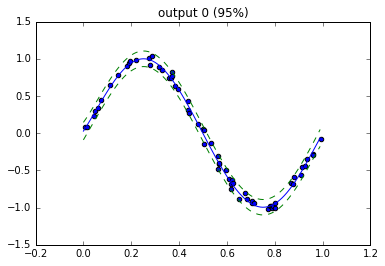

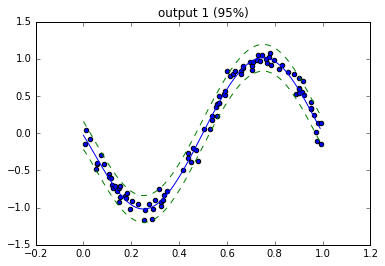

In [17]:
#optimized
print(lmc)
print(lmc.noise)
print_diagram(lmc)

In [18]:
import GPy

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
print(m)


Name : gp
Objective : -180.15398379189142
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  gp.                                    |              value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |  4.18619801055e-08  |      +ve      |        
  sum.ICM0.rbf.lengthscale               |      15.3897634755  |      +ve      |        
  sum.ICM0.B.W                           |             (2, 1)  |               |        
  sum.ICM0.B.kappa                       |               (2,)  |      +ve      |        
  sum.ICM1.rbf.variance                  |   0.00203775895837  |      +ve      |        
  sum.ICM1.rbf.lengthscale               |      0.33963787804  |      +ve      |        
  sum.ICM1.B.W                           |             (2, 1)  |               |        
  sum.ICM1.B.kappa                       |               (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.00250682683773  |

 /usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


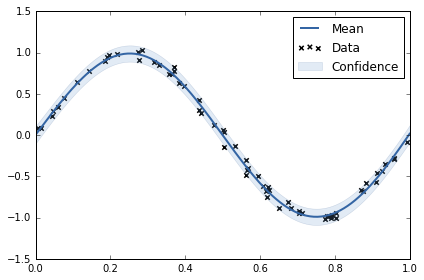

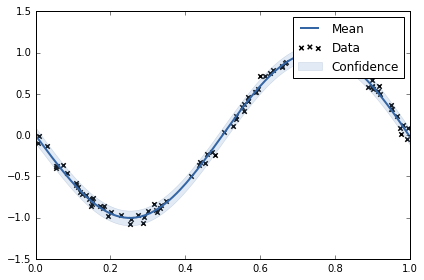

In [8]:
# Plotting code adapted from GPy coregionalization tutorial
# Also 95% confidence

data_rows = np.add.accumulate(n_per_output)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
        plot_limits=(0, 1),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))